In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [3]:
outputVar = 'Risk'

X_train = train.drop(columns= [outputVar],axis=1)
y_train = train[outputVar]

X_test = test.drop(columns= [outputVar],axis=1)
y_test = test[outputVar]

## Random Forest

In [4]:
from skopt.space import Integer, Categorical, Real

space  = [Integer(50, 400, name = 'n_estimators'),
          Integer(1, 200 ,name='max_depth'),
          Integer(1, len(X_train.columns), name='max_features'),
          Integer(1, 10000, name='min_samples_leaf'),
          Integer(2, 10000, name='min_samples_split'),
          Real(0.0, 1, name='ccp_alpha'),
          Categorical([None, 'balanced', 'balanced_subsample'], name='class_weight')
         ]

In [5]:
from sklearn.ensemble import RandomForestClassifier
from skopt.utils import use_named_args
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

myRandom = 0

@use_named_args(space)
def objective(**params):
  tempForest = RandomForestClassifier(**params, random_state = 0)

  global myRandom
  myCV = StratifiedKFold(n_splits=10, shuffle=True, random_state=myRandom)
  scores = cross_val_score(tempForest, X_train, y_train, scoring = 'roc_auc', cv = myCV)
  myRandom = myRandom + 1
  result = scores.mean()
  return -result

In [6]:
from skopt import gp_minimize

start = time.time()
opt = gp_minimize(objective, space, n_calls=300, random_state=0, verbose = False, n_jobs = -1)
runtime = (time.time() - start)/60

print('Optimization finished after ' +
      str(runtime) + 
      ' minutes.')

Optimization finished after 48.77055636246999 minutes.


In [7]:
opt.x

[242, 179, 11, 1, 64, 0.008421313127106677, 'balanced_subsample']

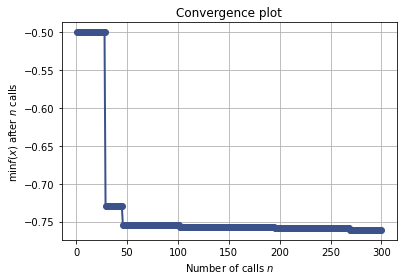

In [8]:
from skopt.plots import plot_convergence

_ = plot_convergence(opt)

In [9]:
optForest = RandomForestClassifier(n_estimators = opt.x[0],
                                   max_depth = opt.x[1],
                                   max_features = opt.x[2],
                                   min_samples_leaf = opt.x[3],
                                   min_samples_split = opt.x[4],
                                   ccp_alpha = opt.x[5],
                                   class_weight = opt.x[6], 
                                   random_state = 0)

_ = optForest.fit(X_train, y_train)

In [10]:
myCV = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
myScore = cross_val_score(optForest, X_train, y_train, scoring = 'roc_auc', cv = myCV).mean()

print('The cross-validation-score of this classifier is ' +
      str(myScore) + 
      '.')

The cross-validation-score of this classifier is 0.7610885281385282.


In [11]:
from sklearn.metrics import roc_auc_score

y_pred = optForest.predict(X_test)

myScore = roc_auc_score(y_test, y_pred)

print('The cross-validation-score of this classifier is ' +
      str(myScore) + 
      ' (testing set).\n')

The cross-validation-score of this classifier is 0.7138173870811073 (testing set).

